# EDA of Dota2 Match Data

Cleaned the Dota 2 match data by removing games that are too short and removed games of the wrong lobby type

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import d2api

In [2]:
APIKey_file = open(r'C:/Users/Erik/Desktop/steam_web_API.txt', 'r')

In [3]:
# overrides the environment variable key
api = d2api.APIWrapper(APIKey_file.readline())

In [4]:
# Reading in the collected match data 
df_match_and_details = pd.read_csv('../data/df_match_and_details.csv')
complete_match_list = df_match_and_details['match'].tolist()
len(complete_match_list)

101372

In [5]:
df_match_and_details.head()

,match,start_time,game_mode,lobby_type,duration,winner,radient_player_1,radient_player_2,radient_player_3,radient_player_4,radient_player_5,dire_player_1,dire_player_2,dire_player_3,dire_player_4,dire_player_5
0,5617764354,1600297049,22,7,1038,dire,Hero(hero_id = 8),Hero(hero_id = 105),Hero(hero_id = 86),Hero(hero_id = 11),Hero(hero_id = 98),Hero(hero_id = 110),Hero(hero_id = 46),Hero(hero_id = 19),Hero(hero_id = 44),Hero(hero_id = 38)
1,5617764355,1600297049,23,0,1518,dire,Hero(hero_id = 40),Hero(hero_id = 19),Hero(hero_id = 54),Hero(hero_id = 69),Hero(hero_id = 105),Hero(hero_id = 70),Hero(hero_id = 93),Hero(hero_id = 51),Hero(hero_id = 86),Hero(hero_id = 58)
2,5617756164,1600296132,22,7,1997,radiant,Hero(hero_id = 5),Hero(hero_id = 36),Hero(hero_id = 13),Hero(hero_id = 14),Hero(hero_id = 41),Hero(hero_id = 126),Hero(hero_id = 84),Hero(hero_id = 10),Hero(hero_id = 100),Hero(hero_id = 21)
3,5617754116,1600295927,22,0,1926,radiant,Hero(hero_id = 60),Hero(hero_id = 15),Hero(hero_id = 34),Hero(hero_id = 104),Hero(hero_id = 107),Hero(hero_id = 65),Hero(hero_id = 70),Hero(hero_id = 126),Hero(hero_id = 31),Hero(hero_id = 108)
4,5617754119,1600295927,22,7,2074,dire,Hero(hero_id = 82),Hero(hero_id = 39),Hero(hero_id = 112),Hero(hero_id = 10),Hero(hero_id = 18),Hero(hero_id = 104),Hero(hero_id = 62),Hero(hero_id = 67),Hero(hero_id = 84),Hero(hero_id = 21)


## Removing all matches that take less than 15 min (900 sec)

Matches that take less than 15 min are not quality matches. Most likely they are matches where someone is having their account's level boosted or people left the game

In [6]:
#looking at the duration match data to determine the average game length
df_match_and_details['duration'].describe()

count    101372.000000
mean       1570.038492
std         470.614112
min           7.000000
25%        1265.000000
50%        1579.000000
75%        1908.000000
max        3116.000000
Name: duration, dtype: float64

In [7]:
#with a quater of games taking 20 minutes, all game under 15 min are most likely not matches that should be included
df_match_and_details[df_match_and_details['duration'] < 900].shape

(7877, 16)

In [8]:
#removing matches less than 15 min
df_match_and_details = df_match_and_details[df_match_and_details['duration'] > 900]

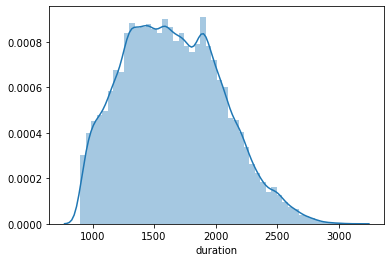

In [9]:
sns.distplot(df_match_and_details['duration']);

### Looking at game type

In [10]:
df_match_and_details.groupby('game_mode').size()

game_mode
2        17
3      6990
4      2469
5        18
18      888
20        1
22    52667
23    30415
dtype: int64

### Game mode
 - 2 is Battle Cup (Event on Saturdays where people make groups of 5 and play for prizes)
 - 3 is Random Draft (Get to pick from 70 choices instead of 119)
 - 4 is Single Draft (Get to pick from 3 choices) -> will remove these games as this is often the pusnshment game type for people who leave too many games
 - 5 is All Random -> removed
 - 18 is Ability Draft -> removed as it doesn't represent heroes matchup correctly
 - 20 is All Random, All Mid -> removed
 - 22 is All Pick
 - 23 is Turbo

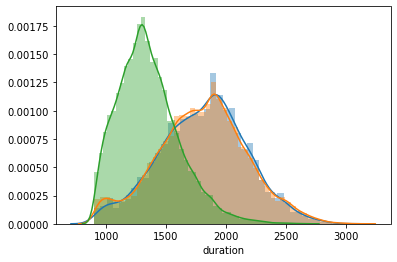

In [11]:
sns.distplot(df_match_and_details[df_match_and_details['game_mode'] == 3]['duration'])
sns.distplot(df_match_and_details[df_match_and_details['game_mode'] == 22]['duration'])
sns.distplot(df_match_and_details[df_match_and_details['game_mode'] == 23]['duration']);

In [12]:
# removing all game types except Random Draft, All-pick, Turbo
df_match_and_details = df_match_and_details[(df_match_and_details['game_mode'] == 3) | (df_match_and_details['game_mode'] == 22) | (df_match_and_details['game_mode'] == 23)]

The Turbo games have a much shorter game lenth as expected

#### In the future would like to have enough data to only focus on all-pick but as Turbo is 1/3 of the data currently, I wont make that distinction yet


### Creating a dictionary of characters and the corresponding id number

In [13]:
api.get_heroes()['heroes'][5]['name'].split("_")[3:]

['drow', 'ranger']

In [14]:
drow_ranger = api.get_heroes()['heroes'][5]['name'].split("_")[3:]
'_'.join(drow_ranger)

'drow_ranger'

In [15]:
heroes = api.get_heroes()['heroes']

In [16]:
heroes_dict = {}
for hero in heroes:
    hero_id = hero['id']
    hero_name = hero['name'].split('_')[3:]
    hero_name = '_'.join(hero_name)
    heroes_dict[f'Hero(hero_id = {hero_id})'] = hero_name

In [17]:
# changing some of the names that no one uses any more
heroes_dict['Hero(hero_id = 11)'] = 'shadow_fiend'
heroes_dict['Hero(hero_id = 36)'] = 'necrophos'
heroes_dict['Hero(hero_id = 42)'] = 'wraith_king'
heroes_dict['Hero(hero_id = 51)'] = 'clockwerk'
heroes_dict['Hero(hero_id = 97)'] = 'magnus'
heroes_dict['Hero(hero_id = 98)'] = 'timbersaw'

In [18]:
heroes_dict;

{'Hero(hero_id = 1)': 'antimage',
 'Hero(hero_id = 2)': 'axe',
 'Hero(hero_id = 3)': 'bane',
 'Hero(hero_id = 4)': 'bloodseeker',
 'Hero(hero_id = 5)': 'crystal_maiden',
 'Hero(hero_id = 6)': 'drow_ranger',
 'Hero(hero_id = 7)': 'earthshaker',
 'Hero(hero_id = 8)': 'juggernaut',
 'Hero(hero_id = 9)': 'mirana',
 'Hero(hero_id = 11)': 'shadow_fiend',
 'Hero(hero_id = 10)': 'morphling',
 'Hero(hero_id = 12)': 'phantom_lancer',
 'Hero(hero_id = 13)': 'puck',
 'Hero(hero_id = 14)': 'pudge',
 'Hero(hero_id = 15)': 'razor',
 'Hero(hero_id = 16)': 'sand_king',
 'Hero(hero_id = 17)': 'storm_spirit',
 'Hero(hero_id = 18)': 'sven',
 'Hero(hero_id = 19)': 'tiny',
 'Hero(hero_id = 20)': 'vengefulspirit',
 'Hero(hero_id = 21)': 'windrunner',
 'Hero(hero_id = 22)': 'zuus',
 'Hero(hero_id = 23)': 'kunkka',
 'Hero(hero_id = 25)': 'lina',
 'Hero(hero_id = 31)': 'lich',
 'Hero(hero_id = 26)': 'lion',
 'Hero(hero_id = 27)': 'shadow_shaman',
 'Hero(hero_id = 28)': 'slardar',
 'Hero(hero_id = 29)': 'tidehun

### Mapping the heroes dict to the match dataframe

In [19]:
df_match_and_details.head(2)

,match,start_time,game_mode,lobby_type,duration,winner,radient_player_1,radient_player_2,radient_player_3,radient_player_4,radient_player_5,dire_player_1,dire_player_2,dire_player_3,dire_player_4,dire_player_5
0,5617764354,1600297049,22,7,1038,dire,Hero(hero_id = 8),Hero(hero_id = 105),Hero(hero_id = 86),Hero(hero_id = 11),Hero(hero_id = 98),Hero(hero_id = 110),Hero(hero_id = 46),Hero(hero_id = 19),Hero(hero_id = 44),Hero(hero_id = 38)
1,5617764355,1600297049,23,0,1518,dire,Hero(hero_id = 40),Hero(hero_id = 19),Hero(hero_id = 54),Hero(hero_id = 69),Hero(hero_id = 105),Hero(hero_id = 70),Hero(hero_id = 93),Hero(hero_id = 51),Hero(hero_id = 86),Hero(hero_id = 58)


In [21]:
# mapping the heroes dictinary with hero names to the match dataframe
complete_df = df_match_and_details
players = ['radient_player_1','radient_player_2','radient_player_3','radient_player_4','radient_player_5','dire_player_1','dire_player_2','dire_player_3','dire_player_4','dire_player_5']
for label in players:
    complete_df[label] = df_match_and_details[label].map(heroes_dict)


In [22]:
complete_df.head()

,match,start_time,game_mode,lobby_type,duration,winner,radient_player_1,radient_player_2,radient_player_3,radient_player_4,radient_player_5,dire_player_1,dire_player_2,dire_player_3,dire_player_4,dire_player_5
0,5617764354,1600297049,22,7,1038,dire,juggernaut,techies,rubick,shadow_fiend,timbersaw,phoenix,templar_assassin,tiny,phantom_assassin,beastmaster
1,5617764355,1600297049,23,0,1518,dire,venomancer,tiny,life_stealer,doom_bringer,techies,ursa,slark,clockwerk,rubick,enchantress
2,5617756164,1600296132,22,7,1997,radiant,crystal_maiden,necrophos,puck,pudge,faceless_void,void_spirit,ogre_magi,morphling,tusk,windrunner
3,5617754116,1600295927,22,0,1926,radiant,night_stalker,razor,tinker,legion_commander,earth_spirit,batrider,ursa,void_spirit,lich,abyssal_underlord
4,5617754119,1600295927,22,7,2074,dire,meepo,queenofpain,winter_wyvern,morphling,sven,legion_commander,bounty_hunter,spectre,ogre_magi,windrunner


In [23]:
#creating the radient and dire teams 
complete_df['radiant'] = 'r_'+complete_df['radient_player_1']+' r_'+complete_df['radient_player_2']+' r_'+complete_df['radient_player_3']+' r_'+complete_df['radient_player_4']+' r_'+complete_df['radient_player_5']
complete_df['dire'] = 'd_'+complete_df['dire_player_1']+' d_'+complete_df['dire_player_2']+' d_'+complete_df['dire_player_3']+' d_'+complete_df['dire_player_4']+' d_'+complete_df['dire_player_5']

### Exporting the complete match dataframe as .csv to use in modeling

In [24]:
complete_df.to_csv("../data/complete_match_df.csv", index=False)